In [14]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gender-detection-and-classification-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3935781%2F6846122%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240605%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240605T181332Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3c0113668ecc520e95499ddc3b80546367e7fa2fde01b836348857dc60c0e5da8e315b9478bb43bd857170885f1ea42d6b4f7eefe9e42d6febebbb00dfba8d8cb5254702c3e74bb22fe00d1d50f8eb1d344bc9acd4ef3342f0a03c11abb12c3287cda378f5f0722d9fe7b2f739261f77c189ab4e1f223bf7ed65dc099efd0aef992d678b5f757090520ed88fa6dbbc450844a8a0892e7de3bae9675a79505ec6f69fad60dfc6f0bb1db418b2370df0e1b240120cd402a2e0b5142e42a38539d83835c9ecab15631f12c1b888c290f2d27abe29ba88141eb41a1bf13e8361cb5aa231b100e1a732e7786629ad9842c656818c3fded3a688a554cbb3def61d24b9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 635160131 bytes downloaded
Downloaded and uncompressed: gender-detection-and-classification-image-dataset
Data source import complete.


In [15]:
import tensorflow as tf
from tensorflow.keras import regularizers, initializers, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense

import matplotlib.pyplot as plt
import numpy as np

In [16]:
train_dir = "/kaggle/input/gender-detection-and-classification-image-dataset/test"
test_dir = "/kaggle/input/gender-detection-and-classification-image-dataset/test"

In [17]:
batch_size = 32
img_size = 224

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      batch_size=batch_size,
                                                      image_size=(img_size, img_size))

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                     batch_size=batch_size,
                                                     image_size=(img_size, img_size))

Found 80 files belonging to 2 classes.
Found 80 files belonging to 2 classes.


In [19]:
class_names = ['man', 'woman']
class_names

['man', 'woman']

In [20]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

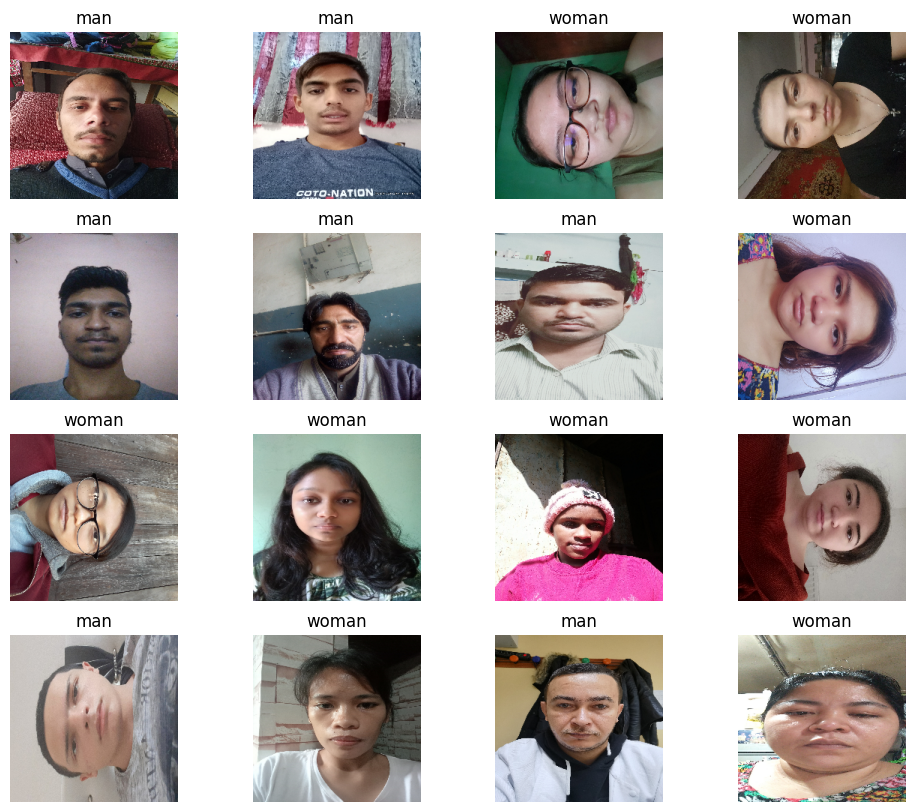

In [21]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(12, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

## Data Augmentation

In [22]:
data_augmentation = Sequential([
    tf.keras.layers.Resizing(180, 180),
    tf.keras.layers.RandomFlip("horizontal_and_vertical")
])

## Visualize Augmented Images

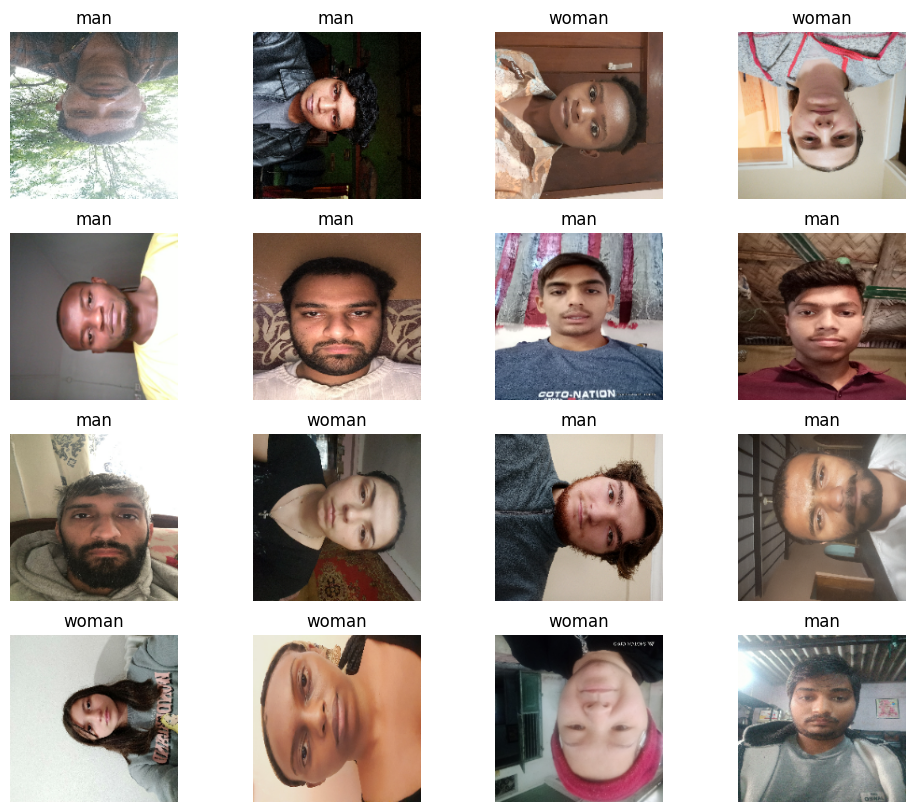

In [23]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(12, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

## Model Creation

In [24]:
regularizer = regularizers.l1(0.001)
initializer = initializers.HeNormal(seed=20)

model = Sequential([
    data_augmentation,
    Conv2D(64, 3, activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer),
    MaxPooling2D((2, 2)),
    Conv2D(32, 3, activation="relu", kernel_initializer=initializer, kernel_regularizer=regularizer),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(10, activation="softmax")
])

In [26]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [27]:
history = model.fit(train_ds, epochs=20)

Epoch 1/20
3/3 [==============================] - 11s 1s/step - loss: 512.6221 - accuracy: 0.3375
Epoch 2/20
3/3 [==============================] - 10s 2s/step - loss: 454.0848 - accuracy: 0.5125
Epoch 3/20
3/3 [==============================] - 8s 1s/step - loss: 102.6317 - accuracy: 0.4500
Epoch 4/20
3/3 [==============================] - 8s 1s/step - loss: 6.1560 - accuracy: 0.6000
Epoch 5/20
3/3 [==============================] - 9s 1s/step - loss: 3.3448 - accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 10s 1s/step - loss: 2.5362 - accuracy: 0.6875
Epoch 7/20
3/3 [==============================] - 9s 2s/step - loss: 2.3173 - accuracy: 0.6500
Epoch 8/20
3/3 [==============================] - 9s 1s/step - loss: 2.3822 - accuracy: 0.6875
Epoch 9/20
3/3 [==============================] - 10s 1s/step - loss: 2.3419 - accuracy: 0.7250
Epoch 10/20
3/3 [==============================] - 9s 2s/step - loss: 2.1643 - accuracy: 0.7875
Epoch 11/20
3/3 [======================

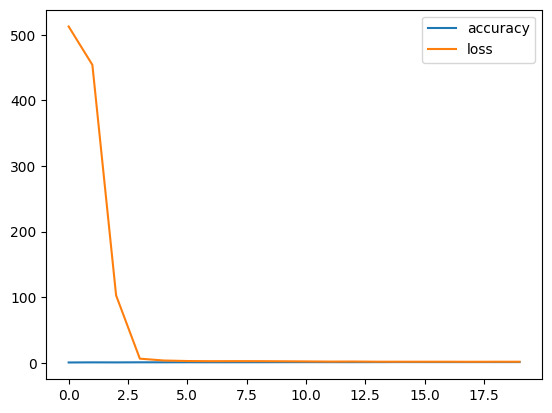

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.legend()

In [29]:
from sklearn.metrics import f1_score

## Test on test dataset

1/1 [==============================] - 0s 114ms/step
[1]
1/1 [==============================] - 0s 30ms/step
[0]
1/1 [==============================] - 0s 32ms/step
[0]


<ipython-input-30-26bef3bbfc92>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Original Label: {class_names[label[i]]} -- Predicted label: {class_names[int(prediction)]}")


1/1 [==============================] - 0s 30ms/step
[1]
1/1 [==============================] - 0s 32ms/step
[0]
1/1 [==============================] - 0s 29ms/step
[0]
1/1 [==============================] - 0s 28ms/step
[1]
1/1 [==============================] - 0s 28ms/step
[1]
1/1 [==============================] - 0s 29ms/step
[1]
1/1 [==============================] - 0s 29ms/step
[0]
1/1 [==============================] - 0s 28ms/step
[1]
1/1 [==============================] - 0s 29ms/step
[0]
1/1 [==============================] - 0s 28ms/step
[1]
1/1 [==============================] - 0s 29ms/step
[1]
1/1 [==============================] - 0s 28ms/step
[1]
1/1 [==============================] - 0s 30ms/step
[1]


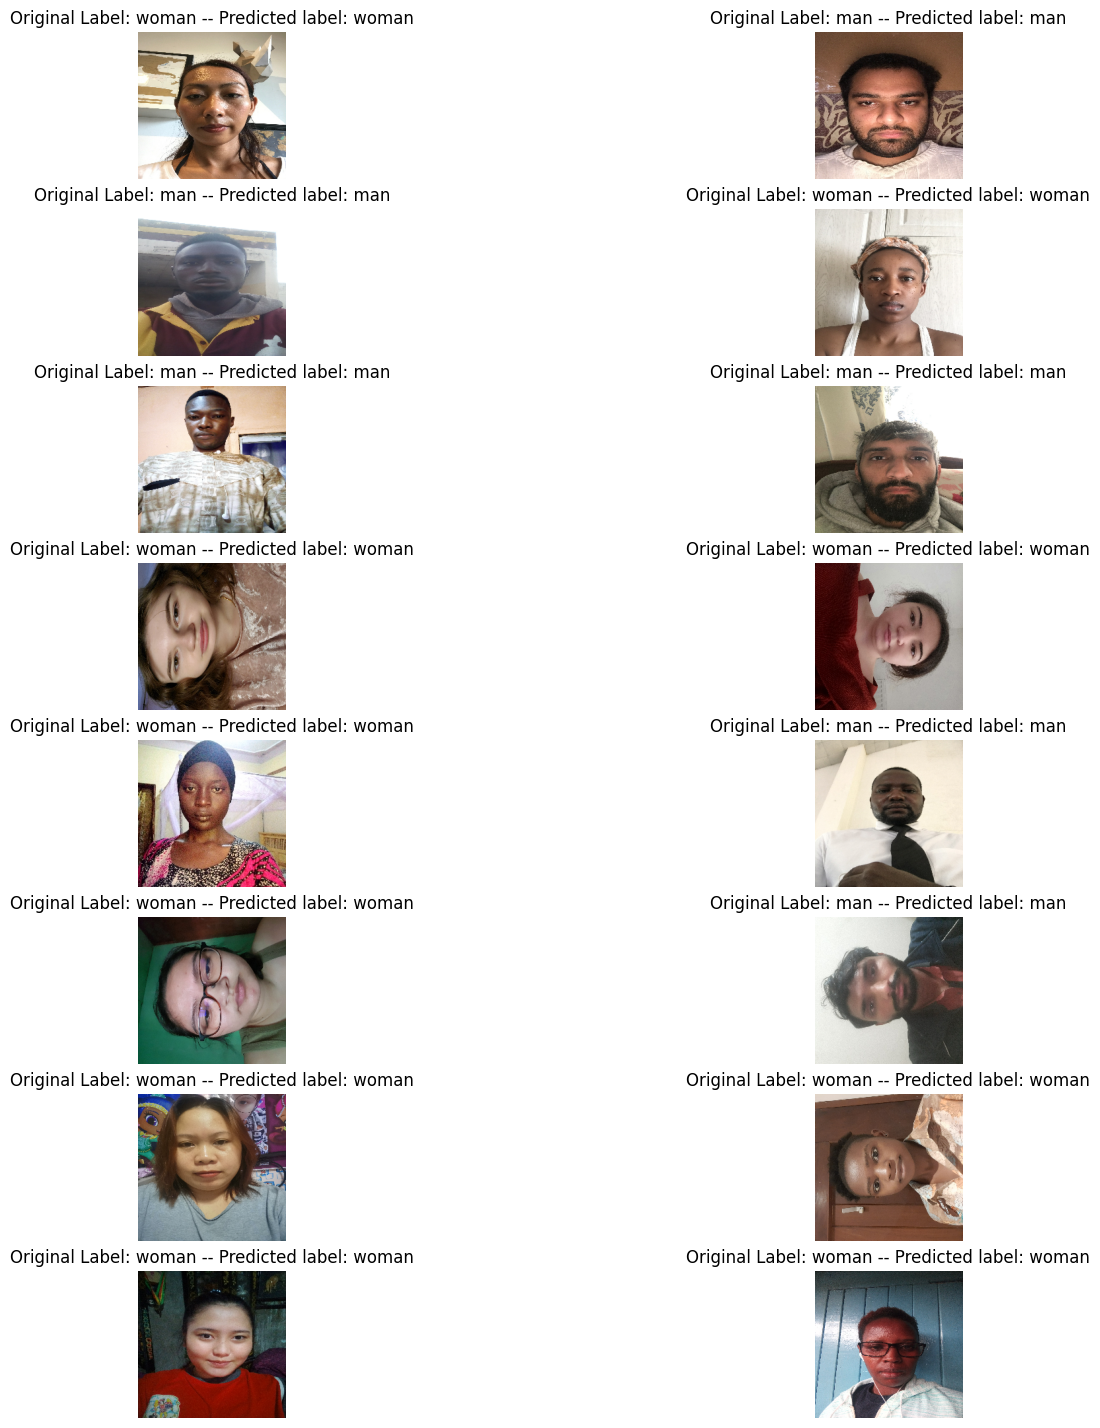

In [30]:
for image, label in test_ds.take(1):
    plt.figure(figsize=(16, 18))
    for i in range(16):
        plt.subplot(8, 2, i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        pred = model.predict(tf.expand_dims(image[i], axis=0))
        prediction = np.argmax(pred, axis=1)
        print(prediction)
        plt.title(f"Original Label: {class_names[label[i]]} -- Predicted label: {class_names[int(prediction)]}")
        plt.axis("off")

In [31]:
model.evaluate(test_ds)

3/3 [==============================] - 5s 358ms/step - loss: 1.4034 - accuracy: 0.9500


[1.4034305810928345, 0.949999988079071]

## Save model

In [32]:
model.save("Gender_classification.keras")